# 3DVar with Lorenz’63
## Pavitra Chandarana, Jan Stüwe

In this notebook, we apply three‐dimensional variational data assimilation to the chaotic Lorenz’63 model using synthetic noisy observations. We enhance the classical 3DVar analysis with a neural‐network–based correction of the analysis increments and assess performance via RMSE and phase‐space diagnostics under different observational settings. Our results demonstrate the promise of hybrid variational–machine learning methods for improving state estimation in low‐dimensional chaotic systems.

In [1]:
### Imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

The Lorenz ’63 system is a classic example of a low-dimensional chaotic dynamical system, governed by the equations:


\begin{aligned}
\dot{x} &= \sigma\,(y - x),\\
\dot{y} &= x\,(\rho - z) - y,\\
\dot{z} &= x\,y - \beta\,z,
\end{aligned}


where the parameters are set to $\sigma = 10, \rho = 28, \beta = \frac{8}{3}.
$

We will now:

1. Integrate the Lorenz equations from $t=0$ to $t=T$ using SciPy’s adaptive RK45 solver with a fixed maximum step size $\Delta t$.
2. Visualize the resulting 3D trajectory.

**Integration settings**:

- Time span: $0 \le t \le T$, with $T = 200$  
- Time step for output: $\Delta t = 0.01$
- Number of steps: $n_{\text{steps}} = T / \Delta t$  
- Initial condition: $\mathbf{x}_0 = [1.0,\,1.0,\,1.0]$

In [2]:
def lorenz63(t, x, sigma=10, rho=28, beta=8/3):
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return [dx, dy, dz]

dt = 0.01
T = 200.0
n_steps = int(T/dt)
times = np.linspace(0, T, n_steps+1)

x0 = [1.0, 1.0, 1.0]

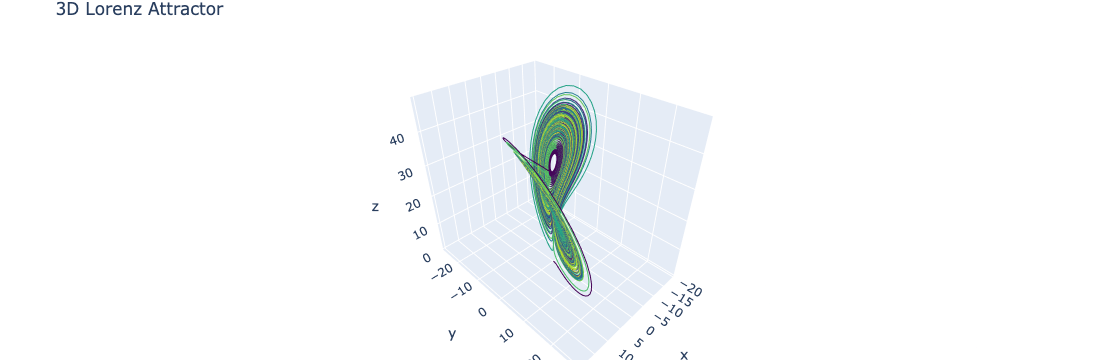

In [4]:
sol = solve_ivp(
    fun=lorenz63,
    t_span=(0, T),
    y0=x0,
    t_eval=times,
    args=(),
    method="RK45",
    max_step=dt
)

traj = sol.y

trace = go.Scatter3d(
    x=traj[0], y=traj[1], z=traj[2],
    mode="lines",
    line=dict(
        width=2,
        color=times,
        colorscale="Viridis"
    )
)

layout = go.Layout(
    title="3D Lorenz Attractor",
    scene=dict(
        xaxis=dict(title='x'),
        yaxis=dict(title='y'),
        zaxis=dict(title='z'),
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

We can observe the typical chaotic behaviour of the system with 2 attractors.

## Task 1: Compute RMSE between multiple Lorenz runs

We compute one "ground-truth" Lorenz'63 run. Afterwards we run 20 more, compute the RMSE to the groundtruth and take the mean.

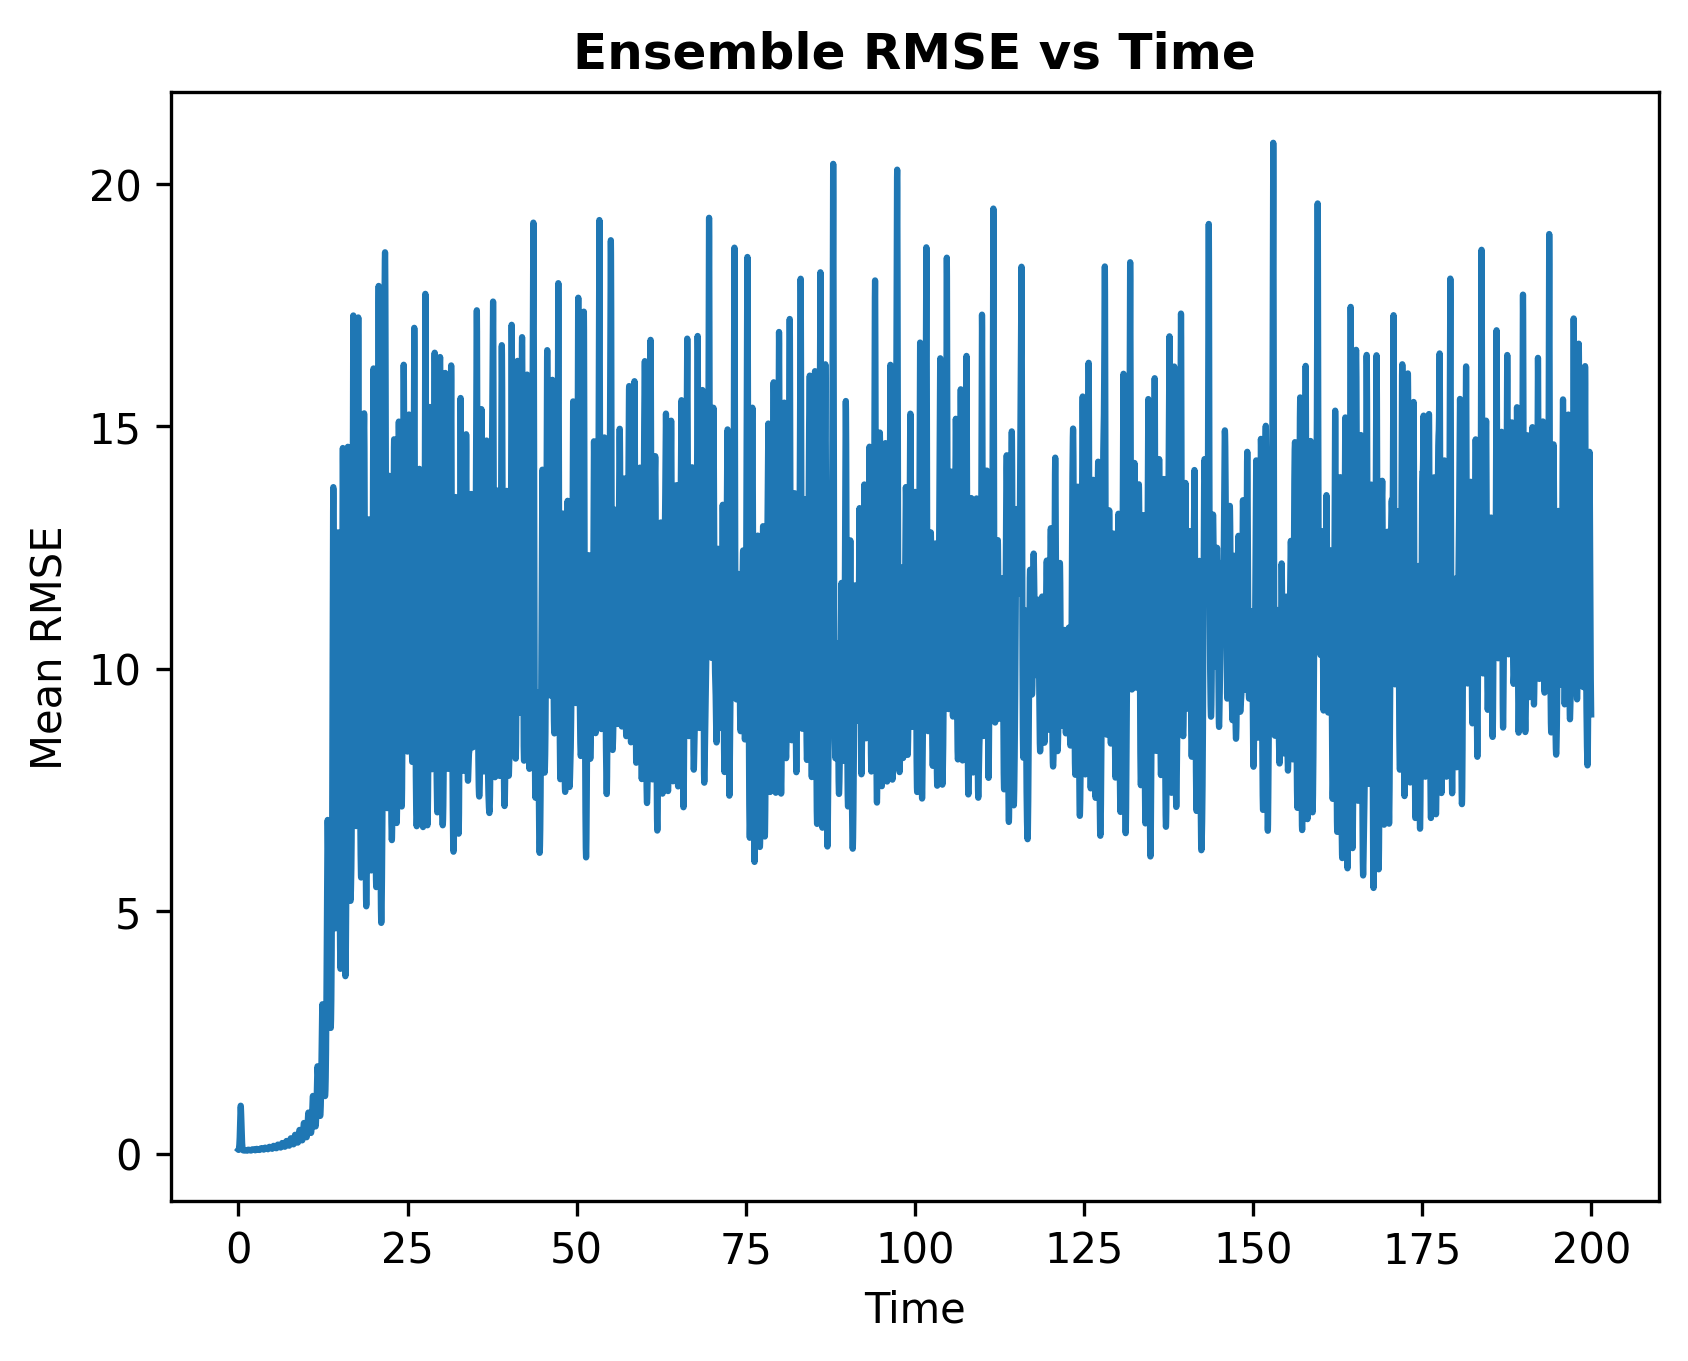

In [10]:
sol_ref = solve_ivp(fun=lorenz63, t_span=(0, T), y0=x0, t_eval=times, max_step=dt)
truth = sol_ref.y

N = 20
perturbs = np.random.normal(scale=0.1, size=(N, 3))
trajectories = np.zeros((N, 3, len(times)))

for i in range(N):
    sol = solve_ivp(fun=lorenz63, t_span=(0, T), y0=x0 + perturbs[i],
                    t_eval=times, max_step=dt)
    trajectories[i] = sol.y

rmse_individual = np.sqrt(np.mean((trajectories - truth[None,:,:])**2, axis=1))  

rmse_mean = rmse_individual.mean(axis=0)

plt.figure(dpi=300)
plt.plot(times, rmse_mean)
plt.xlabel("Time")
plt.ylabel("Mean RMSE")
plt.title("Ensemble RMSE vs Time", fontweight="bold")
plt.show()

We observe that the error is rather small right at the beginning of the dynamical system. As time goes on, the chaotic behaviour takes over and the RMSE grows quite a bit and begins to oscillate.

## Task 2: Compute and visualize the $B$ matrix

At a given analysis time (e.g., say $t = 100$), compute the sample covariance of our background ensemble.

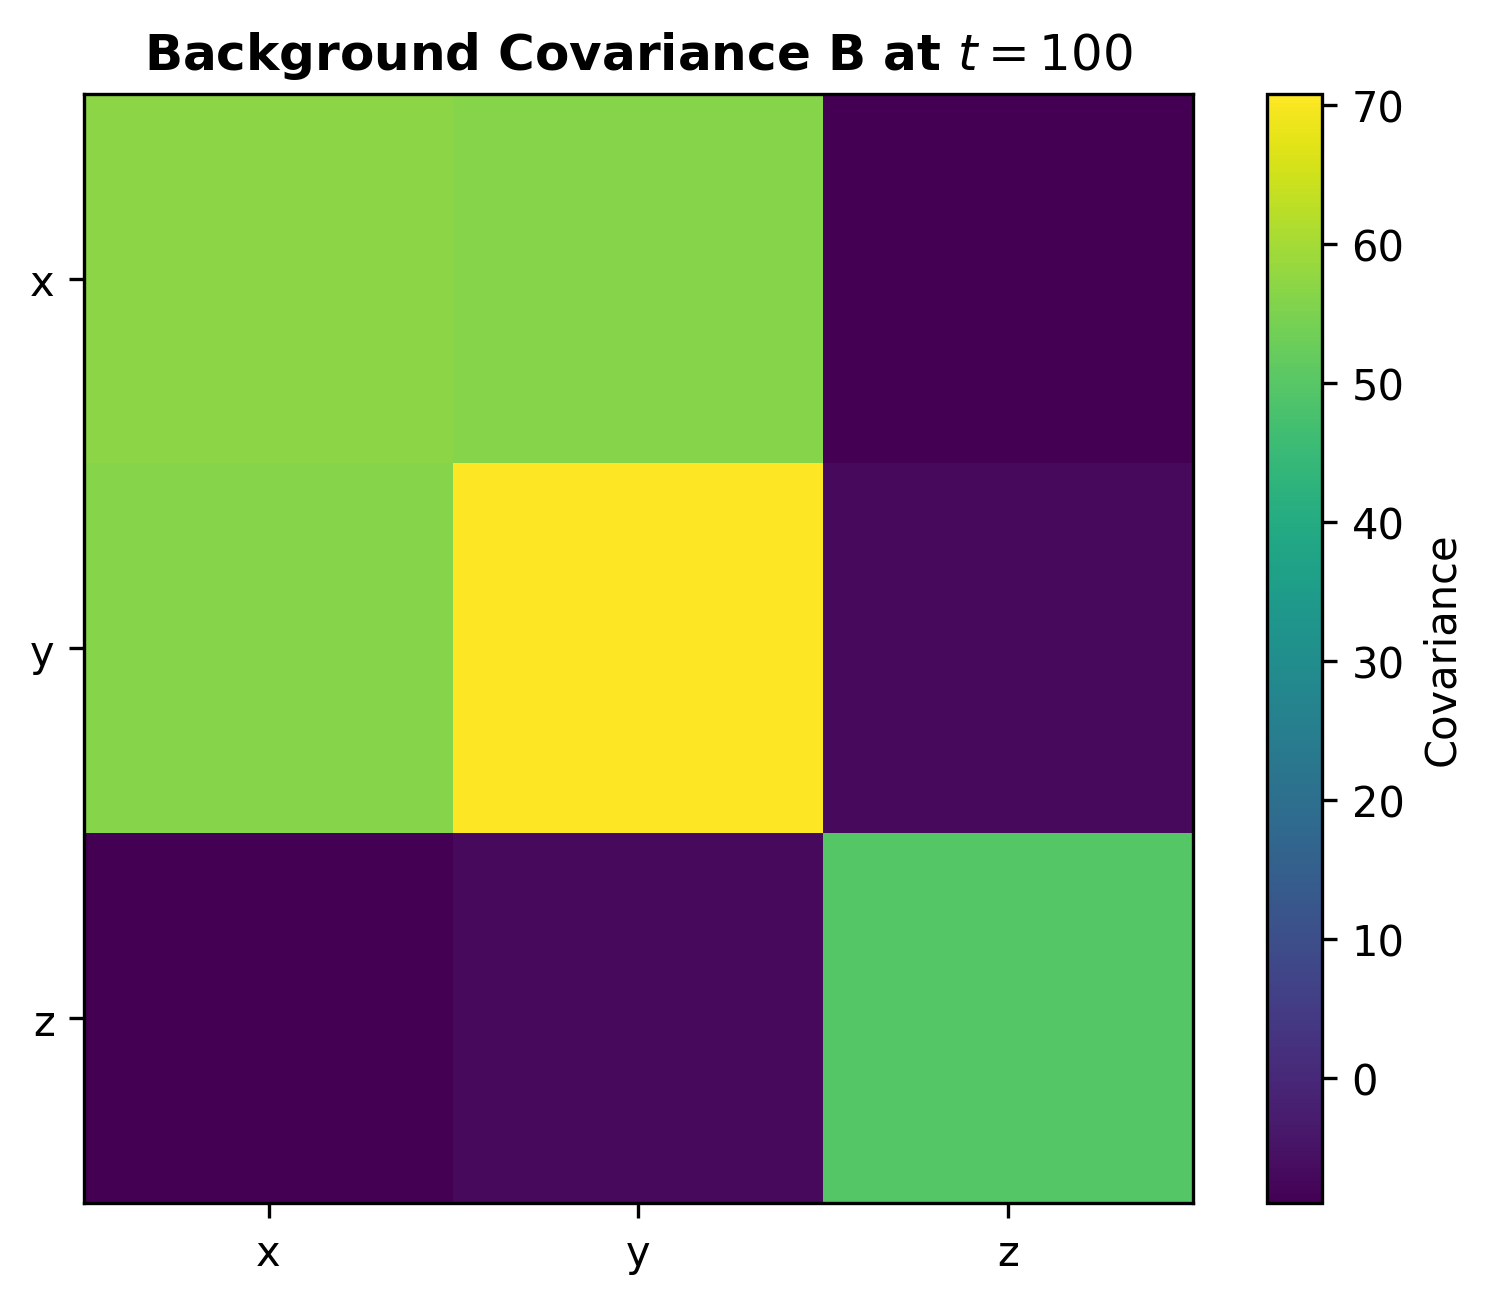

In [15]:
t_idx = np.searchsorted(times, 100.0)

Xb = trajectories[:, :, t_idx]  # shape (N, 3)
xb_mean = Xb.mean(axis=0)

B = np.cov(Xb, rowvar=False, bias=False)

plt.figure(dpi=300)
plt.imshow(B, cmap="viridis", interpolation="none")
plt.colorbar(label="Covariance")
plt.title("Background Covariance B at $t=100$", fontweight="bold")
plt.xticks([0,1,2], ["x","y","z"])
plt.yticks([0,1,2], ["x","y","z"])
plt.show()